# EECS 731 Final Project - Clothing One
## Clustering

In [61]:
import pandas as pd
import pickle

In [62]:
reviews = pickle.load(open("../Data/reviews.pkl", "rb" ))
rented_for_encoding = pickle.load(open("../Data/rented_for_encoding.pkl", "rb"))
body_type_encoding = pickle.load(open("../Data/body_type_encoding.pkl", "rb"))
category_encoding = pickle.load(open("../Data/category_encoding.pkl", "rb"))

In [63]:
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2


In [64]:
rented_for_encoding.head()

,encoding
labels,
date,0
everyday,1
formal affair,2
other,3
party,4


In [65]:
body_type_encoding.head()

,encoding
labels,
apple,0
athletic,1
full bust,2
hourglass,3
pear,4


In [66]:
category_encoding.head()

,encoding
labels,
ballgown,0
blazer,1
blouse,2
blouson,3
bomber,4


In [67]:
userDetails = reviews[['age', 'body_type','height','weight', 'user_id', 'bust_volume', 'bust_height']].copy()
#add weight to the body_type by creating another column and cubing it - CONSIDER REMOVING THIS

print('userDetails Length: ' + str(len(userDetails)))
userDetails.head()

userDetails Length: 146381


,age,body_type,height,weight,user_id,bust_volume,bust_height
0,28,3,68.0,137,420272,590,4
1,36,6,66.0,132,273551,390,2
2,34,4,65.0,135,909926,480,3
3,27,1,69.0,145,151944,390,2
4,45,1,68.0,138,734848,310,2


In [68]:
#One-hot encode body_type for KMEANS

b = body_type_encoding.copy()
b.reset_index(inplace=True)

dictBody_type = b.to_dict()
for i, row in b.iterrows():
    userDetails[row['labels']] = 0
    
for index, row in userDetails.iterrows():
    userDetails.at[index, dictBody_type['labels'][row['body_type']]] = 1
    
userDetails.drop(columns=['body_type'],inplace = True)
print(userDetails.head())


   age  height  weight  user_id  bust_volume  bust_height  apple  athletic  \
0   28    68.0     137   420272          590            4      0         0   
1   36    66.0     132   273551          390            2      0         0   
2   34    65.0     135   909926          480            3      0         0   
3   27    69.0     145   151944          390            2      0         1   
4   45    68.0     138   734848          310            2      0         1   

   full bust  hourglass  pear  petite  straight & narrow  
0          0          1     0       0                  0  
1          0          0     0       0                  1  
2          0          0     1       0                  0  
3          0          0     0       0                  0  
4          0          0     0       0                  0  


In [69]:
#drop duplicates of user info (if the same user submitted multiple reviews), then drop user_id
userDetailsNoDuplicates = userDetails.drop_duplicates(keep = 'first').copy()
print('userDetailsNoDuplicates Length: ' + str(len(userDetailsNoDuplicates)))
userIdsNoDups = userDetailsNoDuplicates['user_id'].copy()
userDetailsNoDuplicates.reset_index(inplace=True)
userDetailsNoDuplicates.drop(columns=['user_id', 'index'], inplace=True)

userDetailsNoDuplicates.head()

userDetailsNoDuplicates Length: 77347


,age,height,weight,bust_volume,bust_height,apple,athletic,full bust,hourglass,pear,petite,straight & narrow
0,28,68.0,137,590,4,0,0,0,1,0,0,0
1,36,66.0,132,390,2,0,0,0,0,0,0,1
2,34,65.0,135,480,3,0,0,0,0,1,0,0
3,27,69.0,145,390,2,0,1,0,0,0,0,0
4,45,68.0,138,310,2,0,1,0,0,0,0,0


## Model 1 - KMEANS

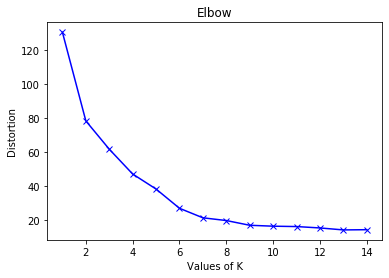

In [70]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {}
mapping2 = {} 
K = range(1,15, 1) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(userDetailsNoDuplicates) 
    kmeanModel.fit(userDetailsNoDuplicates)     
      
    distortions.append(sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(userDetailsNoDuplicates, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / userDetailsNoDuplicates.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Elbow') 
plt.show() 

In [71]:
#predict for our data set
numClusters = 7
print(userDetailsNoDuplicates.head())
kmeans =  KMeans(n_clusters=numClusters, random_state=0).fit(userDetailsNoDuplicates)
kmeansResults = kmeans.predict(userDetailsNoDuplicates)
print(kmeansResults)

   age  height  weight  bust_volume  bust_height  apple  athletic  full bust  \
0   28    68.0     137          590            4      0         0          0   
1   36    66.0     132          390            2      0         0          0   
2   34    65.0     135          480            3      0         0          0   
3   27    69.0     145          390            2      0         1          0   
4   45    68.0     138          310            2      0         1          0   

   hourglass  pear  petite  straight & narrow  
0          1     0       0                  0  
1          0     0       0                  1  
2          0     1       0                  0  
3          0     0       0                  0  
4          0     0       0                  0  
[0 4 2 ... 0 0 2]


In [72]:
userDetailsNoDupsResults =userDetailsNoDuplicates.copy()
userDetailsNoDupsResults['kmeans_cluster'] = pd.DataFrame(kmeansResults)
userDetailsNoDupsResults.head()

,age,height,weight,bust_volume,bust_height,apple,athletic,full bust,hourglass,pear,petite,straight & narrow,kmeans_cluster
0,28,68.0,137,590,4,0,0,0,1,0,0,0,0
1,36,66.0,132,390,2,0,0,0,0,0,0,1,4
2,34,65.0,135,480,3,0,0,0,0,1,0,0,2
3,27,69.0,145,390,2,0,1,0,0,0,0,0,4
4,45,68.0,138,310,2,0,1,0,0,0,0,0,1


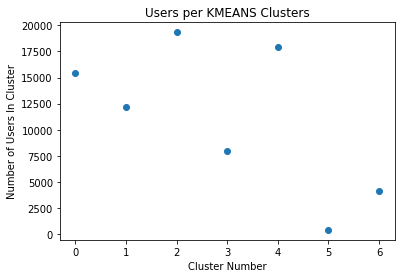

In [73]:
#visualize the clusters
dict = {}

for i, row in userDetailsNoDupsResults.iterrows():    
    dict[row['kmeans_cluster']] = dict.get(row['kmeans_cluster'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:numClusters]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Users In Cluster') 
plt.title('Users per KMEANS Clusters') 
plt.show() 

In [74]:
userDetails['kmeans_cluster'] = kmeans.predict(userDetails.drop(columns=['user_id']))
reviews['kmeans_cluster'] = userDetails['kmeans_cluster'].copy()
reviews.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,0
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,4
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,2
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,4
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,1


## Model 2 - Mean Shift

In [75]:
from sklearn.cluster import MeanShift
clustering = MeanShift(bandwidth = 2).fit(userDetailsNoDuplicates)
#bandwith was a bottleneck here (specifically estimate_bandwith function ) https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
res = clustering.predict(userDetails.drop(columns=['kmeans_cluster', 'user_id']))
clustering.labels_


array([594, 488,  46, ..., 336, 309, 153])

Chose these two models for technical reasons {1} and {2} and also because we wanted a static predict function, which many others didn't have. This is used to find a cluster that a specific use is in, rather than creating clusters with all users repeatedly

In [76]:
userDetails['mean_shift_cluster'] = res

resNoDups = pd.DataFrame(clustering.predict(userDetailsNoDuplicates))
resNoDups.columns=['mean_shift_cluster']
resNoDups.head()


,mean_shift_cluster
0,594
1,488
2,46
3,710
4,6048


Number of Clusters: 9121


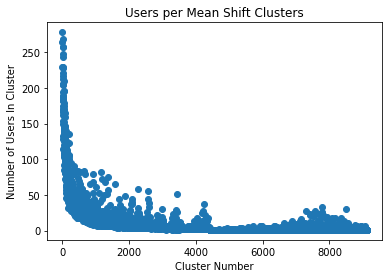

In [77]:
# scatter plot of the clusters for mean shift
print("Number of Clusters: " + str(resNoDups['mean_shift_cluster'].nunique()))
#visualize the clusters
dict = {}

for i, row in resNoDups.iterrows():    
    dict[row['mean_shift_cluster']] = dict.get(row['mean_shift_cluster'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:resNoDups['mean_shift_cluster'].nunique()]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Users In Cluster') 
plt.title('Users per Mean Shift Clusters') 
plt.show() 

## Post-Model Refinement

* User submits data, then they are assigned to a cluster
* Filter by occassion
* Consider most common items for a specific occasion
* Generate score combining date (recent better), rating, and percentage of users who said item fit

In [78]:
reviewsToFilter = reviews.copy()
reviewsToFilter.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,28,3,44,fit,68.0,2260466,10,6,2016-04-20,14,420272,137,590,4,0
1,36,6,20,fit,66.0,153475,10,3,2013-06-18,12,273551,132,390,2,4
2,34,4,16,fit,65.0,126335,8,2,2014-02-12,8,909926,135,480,3,2
3,27,1,20,fit,69.0,616682,10,7,2016-09-26,12,151944,145,390,2,4
4,45,1,16,fit,68.0,364092,8,0,2016-04-30,8,734848,138,310,2,1


In [79]:
#this corresponds to rented_for
userOccasion = 6
#assign a user to a body cluster (they would use the model to be fitted)
userBodyCluster = 1

reviewsByOccasion = reviewsToFilter[reviewsToFilter['rented_for'] == userOccasion]
reviewsByOccasion = reviewsByOccasion[reviewsByOccasion['kmeans_cluster'] == userBodyCluster]
reviewsByOccasion.reset_index(drop=True, inplace=True)
print('Number of occasion instances: ' + str(len(reviewsByOccasion)))
reviewsByOccasion.head()

Number of occasion instances: 437


,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster
0,36,6,44,fit,69.0,2429745,10,6,2017-03-24,8,434928,125,310,2,1
1,29,5,16,fit,61.0,1166477,10,6,2017-06-01,4,59971,115,310,1,1
2,32,6,26,fit,70.0,2653183,6,6,2015-06-21,2,893909,120,310,2,1
3,32,4,46,small,64.0,226278,10,6,2016-07-10,8,122707,120,310,2,1
4,54,6,16,fit,64.0,175496,10,6,2016-08-10,8,923187,130,310,1,1


In [80]:
# generate most common item categories for occasion
catCounts = reviewsByOccasion['category'].value_counts().to_frame()
catCounts.columns=['count']
catCounts.head()

,count
16,219
45,36
44,30
32,25
26,22


In [81]:
#Generate a score combining date (recent better), rating, and percentage of users who said item fit

# date score = 10 * 1 / fourth root(days since review_date) # Max score is 10, start with most recent date in set
# rating score = 1 * rating
# fit score = 10 * percentage of users who said item fit

mostRecentDate = reviewsByOccasion['review_date'].max()

#fit score
reviewsPerItem = reviewsByOccasion['item_id'].value_counts().to_frame()
reviewsPerItem.columns=['count']
reviewsPerItem['fit_count'] = 0
reviewsPerItem.head()

for index, row in reviewsByOccasion.iterrows():
    if (row['fit'] == 'fit'):
        reviewsPerItem.at[row['item_id'], 'fit_count'] = reviewsPerItem.at[row['item_id'], 'fit_count'] + 1

reviewsPerItem['ratio'] = reviewsPerItem['fit_count'] / reviewsPerItem['count']
reviewsPerItem.head()

,count,fit_count,ratio
963476,7,7,1.000000
172027,6,5,0.833333
166633,5,5,1.000000
127495,4,3,0.750000
1331220,4,2,0.500000


In [97]:
def cube_root(num):
    return num ** (1. / 3)

reviewsByOccasion['fit_score'] = 0
fitDict = reviewsPerItem.drop(columns=['count', 'fit_count']).to_dict()

for index, row in reviewsByOccasion.iterrows():
    reviewsByOccasion.loc[index, 'fit_score'] = fitDict['ratio'][int(row['item_id'])] * 10

reviewsByOccasion['priority_score'] = (20 / cube_root((mostRecentDate - reviewsByOccasion['review_date']).dt.days)) + reviewsByOccasion['rating'] + reviewsByOccasion['fit_score']
reviewsByOccasion.drop(columns=['fit_score'], inplace = True)

reviewsByOccasion.head()

,age,body_type,category,fit,height,item_id,rating,rented_for,review_date,size,user_id,weight,bust_volume,bust_height,kmeans_cluster,priority_score
0,36,6,44,fit,69.0,2429745,10,6,2017-03-24,8,434928,125,310,2,1,23.032048
1,29,5,16,fit,61.0,1166477,10,6,2017-06-01,4,59971,115,310,1,1,23.323108
2,32,6,26,fit,70.0,2653183,6,6,2015-06-21,2,893909,120,310,2,1,18.049705
3,32,4,46,small,64.0,226278,10,6,2016-07-10,8,122707,120,310,2,1,12.449987
4,54,6,16,fit,64.0,175496,10,6,2016-08-10,8,923187,130,310,1,1,22.498375


In [83]:
recItems = reviewsByOccasion[['category', 'item_id', 'priority_score']].copy()
recItems = recItems[recItems['priority_score'] < 1000]
recItems.sort_values(by='priority_score', inplace = True, ascending= False)
recItems.head()

,category,item_id,priority_score
179,16,518200,35.874011
46,23,2379432,31.006424
223,4,2727275,30.455159
321,10,2729447,30.000000
184,16,1263144,30.000000


In [96]:
#Get top three items from top three categories

print("Top Categories")
print(catCounts.head())
#select the top three categories
cat16 = recItems[recItems['category'] == 16]
cat45 = recItems[recItems['category'] == 45]
cat44 = recItems[recItems['category'] == 44]


Top Categories
    count
16    219
45     36
44     30
32     25
26     22


In [93]:
cat16.head()

,category,item_id,priority_score
179,16,518200,35.874011
184,16,1263144,30.000000
207,16,614741,30.000000
120,16,946530,26.839904
397,16,1333481,26.509745


In [94]:
cat45.head()

,category,item_id,priority_score
344,45,542348,27.249202
182,45,1526453,26.173579
150,45,1348294,24.974226
219,45,532252,24.043600
131,45,1774617,23.948883


In [95]:
cat44.head()

,category,item_id,priority_score
338,44,2125959,24.763792
293,44,2484216,24.043600
78,44,2063202,23.755816
181,44,2771463,23.472846
224,44,2553295,23.313008
